# FBS with Noisy FRFs
This notebook shows an example of how measurement errors in the FRFs can lead to errors in the FBS coupled FRFs. As a reminder, a graphic of the FBS coupling is shown below, where system A is on the left, system B is on the right, and the coupled system is in the center. 

![Two_DOF_System](./Images/TwoMassSystem.svg)

## General Process for this Example
This example computes the FRFs of the uncoupled systems from a simulated modal test, where time responses are computed with time integration on the mass, stiffness and damping matrices. Noise and quantization error are added to the responses and forces prior to the FRF computation to simulate common measurement errors. 

## Importing Information for the Example
This section imports the necessary packages and data for the 2DOF example systems for the example. The data for the uncoupled systems are imported as SDynPy `System` objects and are called `system_a` and `system_b`. The truth FRFs are still imported as a SDynPy `TransferFunctionArray` and are called `system_a_frfs`, `system_b_frfs`, and `coupled_system_frfs`. 

In [1]:
import numpy as np
import sdynpy as sdpy
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
from scipy.signal.windows import tukey

In [2]:
system_a = sdpy.System.load(r'./example_systems/system_a.npz')
system_b = sdpy.System.load(r'./example_systems/system_b.npz')

system_a_truth_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_a_frfs.npz')
system_b_truth_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_b_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_system_frfs.npz')

## Generate the Simulated Modal Test Data
This section generates the data for the simulated modal tests on systems A and B. It goes through the following steps:

1. Random excitation will be generated for all the DOFs in systems A and B with different excitation for each system. 
2. The time response will for each system will be computed via time integration with the `time_integrate` method for SDynPy `System` objects.
3. Noise and quantization errors will be added to both the responses and forces.
4. FRFs will be computed for both systems A and B from the noised data.

The sampling parameters for the simulated test are defined in the following code block.

In [ ]:
sampling_frequency = 150 # Hz
block_time = 10 # seconds
window = 'hann'
overlap = 0.5
number_samples = int((100*overlap + 1)*block_time*sampling_frequency)

### Generating Random Excitation
The random excitation is generated using a random number generator with a supplied seed to obtain the same excitation over multiple runs. A tukey window is applied to the forces to avoid a significant transient response at the start of the excitation.  

In [4]:
force_window = tukey(number_samples, alpha=0.05)
system_a_rng = np.random.default_rng(seed=504)
system_a_forces = system_a_rng.normal(loc=0, size=(2,number_samples))*force_window

system_b_rng = np.random.default_rng(seed=1212)
system_b_forces = system_b_rng.normal(loc=0, size=(2,number_samples))*force_window

The forces are filtered with a 2-60 Hz bandpass filter to mimic a similar excitation bandwidth that is encountered in modal testing, where low frequencies are typically filtered out to reduce rigid body motions and a highpass anti-alias filter is applied. This filter is 10th order Butterworth filter that is implemented with second order sections and applied with the typical zero-phase filtering approach. 

In [5]:
force_filter = butter(10, (2,60), btype='bandpass', output='sos', fs=sampling_frequency)

system_a_forces = sosfiltfilt(force_filter, system_a_forces)
system_b_forces = sosfiltfilt(force_filter, system_b_forces)

### Computing the Responses
The responses are computed with the `time_integrate` method for SDynPy `System` objects with an integration over sample of ten.

```{note}
The `displacement_derivative` kwarg is set to two so the resulting time data is in acceleration format.
```

In [ ]:
system_a_response, system_a_force = system_a.time_integrate(system_a_forces, 
                                                            dt=1/sampling_frequency, 
                                                            references=system_a.coordinate, 
                                                            integration_oversample=10, 
                                                            displacement_derivative=2)

system_b_response, system_b_force = system_b.time_integrate(system_b_forces, 
                                                            dt=1/sampling_frequency, 
                                                            references=system_b.coordinate, 
                                                            integration_oversample=10, 
                                                            displacement_derivative=2)

### Adding Noise and Quantization Errors
Noise and quantization error are added to the responses using a bespoke function that was created for this example. The parameters in this function were tuned to roughly simulate a signal-to-noise ratio of 20 dB, with a 24 bit ADC where the range of the ADC was set to 20x the maximum value in the time data. Like the random excitation, a seed value is supplied to the random number generator to get the same simulated noise over multiple runs. 

In [ ]:
def quantize_and_add_noise(time_data, random_seed):
    """
    Adds noise and quantization error to the supplied time data.

    Parameters
    ----------
    time_data : TimeHistoryArray
        The time data to add noise and quantization error to.
    random_seed : int
        The seed value for the random number generator for the simulated noise.

    Returns
    -------
    noised_quantized_data : TimeHistoryArray
        The time data with added noise and quantization error.
    """
    time_rms = np.mean(time_data.rms())

    rng = np.random.default_rng(random_seed)
    noise_time = rng.normal(loc=0, size=(time_data.ordinate.shape[0], 
                                         time_data.ordinate.shape[1]))*time_rms/10
    noised_data = time_data.ordinate + noise_time

    number_bits = 24
    number_bins = 2**int(number_bits)
    adc_resolution = (np.abs(time_data.ordinate).max()*20)/number_bins
    noised_quantized_data = adc_resolution*np.round(noised_data/adc_resolution)

    return sdpy.data_array(sdpy.data.FunctionTypes.TIME_RESPONSE, 
                           time_data.ravel().abscissa[0], 
                           noised_quantized_data, 
                           time_data.response_coordinate[...,np.newaxis])

In [ ]:
system_a_response_noised = quantize_and_add_noise(system_a_response, 305)
system_a_forces_noised = quantize_and_add_noise(system_a_force, 924)

system_b_response_noised = quantize_and_add_noise(system_b_response, 38)
system_b_forces_noised = quantize_and_add_noise(system_b_force, 43)

### Computing the FRFs
The FRFs are computed using the `from_time_data` method for the `TransferFunctionArray` object in SDynPy. The signal processing settings for computing the FRFs are:
- Frequency Resolution (set via `samples_per_average`) - 0.1 Hz
- Window - hann
- Overlap - 50%
- Number of Averages - 101
- FRF Estimator - H1

In [ ]:
system_a_frf_noise = sdpy.TransferFunctionArray.from_time_data(reference_data=system_a_forces_noised, 
                                                               response_data=system_a_response_noised, 
                                                               samples_per_average=sampling_frequency*block_time, 
                                                               overlap=overlap, 
                                                               method='H1', 
                                                               window=window)

In [ ]:
system_b_frf_noise = sdpy.TransferFunctionArray.from_time_data(reference_data=system_b_forces_noised, 
                                                               response_data=system_b_response_noised, 
                                                               samples_per_average=sampling_frequency*block_time, 
                                                               overlap=overlap, 
                                                               method='H1', 
                                                               window=window)

The effects of the measurement errors on the estimated FRFs can be seen via a graphical comparison between the noisy and truth driving point FRFs for systems A and B, which is shown below for the excitation passband frequency range. As expected, the noise primarily effects the low responding frequencies at low frequencies and anti-resonances. 

Close inspection also reveals that the peak amplitudes at the natural frequencies are incorrect for some DOFs and natural frequencies. The error in the peak amplitudes is assumed to be caused by leakage from the windowing scheme. In the effected frequency ranges, the noisy FRFs appear to be an example of FRFs with moderately high noise floors, based on the experience of the author. 

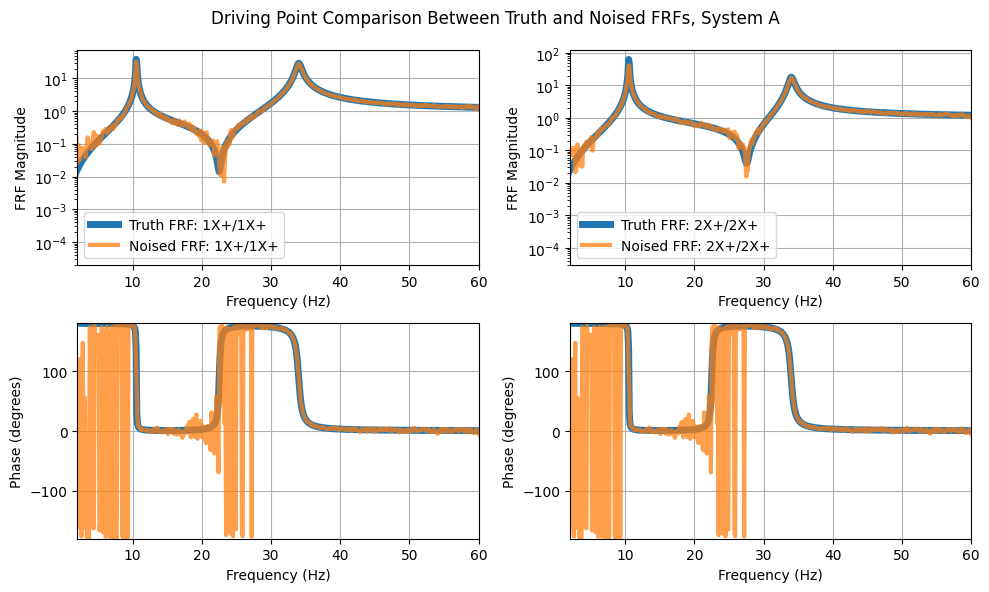

In [ ]:
freq_truth = system_a_truth_frfs.ravel().abscissa[0]
freq_noised = system_a_frf_noise.ravel().abscissa[0]

fig, ax = plt.subplots(2,2)
ax[0,0].semilogy(freq_truth, np.abs(system_a_truth_frfs[0,0].ordinate), 
                 label='Truth FRF: 1X+/1X+', linewidth=5)
ax[0,0].semilogy(freq_noised, np.abs(system_a_frf_noise[0,0].ordinate), 
                 label='Noised FRF: 1X+/1X+', linewidth=3, alpha=0.75)
ax[0,0].set_xlim(left=2, right=60)
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('FRF Magnitude')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].plot(freq_truth, np.angle(system_a_truth_frfs[0,0].ordinate)*180/np.pi, 
             linewidth=5)
ax[1,0].plot(freq_noised, np.angle(system_a_frf_noise[0,0].ordinate)*180/np.pi, 
             linewidth=3, alpha=0.75)
ax[1,0].set_xlim(left=2, right=60)
ax[1,0].set_ylim(top=180, bottom=-180)
ax[1,0].grid()
ax[1,0].set_ylabel('Phase (degrees)')
ax[1,0].set_xlabel('Frequency (Hz)')

ax[0,1].semilogy(freq_truth, np.abs(system_a_truth_frfs[1,1].ordinate), 
                 label='Truth FRF: 2X+/2X+', linewidth=5)
ax[0,1].semilogy(freq_noised, np.abs(system_a_frf_noise[1,1].ordinate), 
                 label='Noised FRF: 2X+/2X+', linewidth=3, alpha=0.75)
ax[0,1].set_xlim(left=2, right=60)
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('FRF Magnitude')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].plot(freq_truth, np.angle(system_a_truth_frfs[0,0].ordinate)*180/np.pi, 
             linewidth=5)
ax[1,1].plot(freq_noised, np.angle(system_a_frf_noise[0,0].ordinate)*180/np.pi, 
             linewidth=3, alpha=0.75)
ax[1,1].set_xlim(left=2, right=60)
ax[1,1].set_ylim(top=180, bottom=-180)
ax[1,1].grid()
ax[1,1].set_ylabel('Phase (degrees)')
ax[1,1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noised FRFs, System A')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

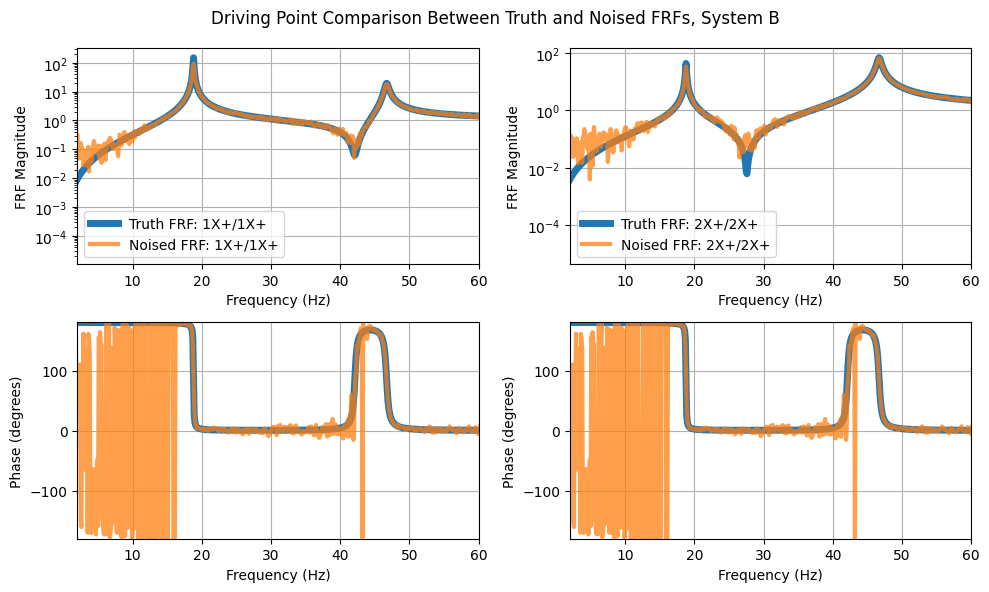

In [ ]:
freq_truth = system_b_truth_frfs.ravel().abscissa[0]
freq_noised = system_b_frf_noise.ravel().abscissa[0]

fig, ax = plt.subplots(2,2)
ax[0,0].semilogy(freq_truth, np.abs(system_b_truth_frfs[0,0].ordinate), 
                 label='Truth FRF: 3X+/3X+', linewidth=5)
ax[0,0].semilogy(freq_noised, np.abs(system_b_frf_noise[0,0].ordinate), 
                 label='Noised FRF: 3X+/3X+', linewidth=3, alpha=0.75)
ax[0,0].set_xlim(left=2, right=60)
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('FRF Magnitude')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].plot(freq_truth, np.angle(system_b_truth_frfs[0,0].ordinate)*180/np.pi, 
             linewidth=5)
ax[1,0].plot(freq_noised, np.angle(system_b_frf_noise[0,0].ordinate)*180/np.pi, 
             linewidth=3, alpha=0.75)
ax[1,0].set_xlim(left=2, right=60)
ax[1,0].set_ylim(top=180, bottom=-180)
ax[1,0].grid()
ax[1,0].set_ylabel('Phase (degrees)')
ax[1,0].set_xlabel('Frequency (Hz)')

ax[0,1].semilogy(freq_truth, np.abs(system_b_truth_frfs[1,1].ordinate), 
                 label='Truth FRF: 4X+/4X+', linewidth=5)
ax[0,1].semilogy(freq_noised, np.abs(system_b_frf_noise[1,1].ordinate), 
                 label='Noised FRF: 4X+/4X+', linewidth=3, alpha=0.75)
ax[0,1].set_xlim(left=2, right=60)
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('FRF Magnitude')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].plot(freq_truth, np.angle(system_b_truth_frfs[0,0].ordinate)*180/np.pi, 
             linewidth=5)
ax[1,1].plot(freq_noised, np.angle(system_b_frf_noise[0,0].ordinate)*180/np.pi, 
             linewidth=3, alpha=0.75)
ax[1,1].set_xlim(left=2, right=60)
ax[1,1].set_ylim(top=180, bottom=-180)
ax[1,1].grid()
ax[1,1].set_ylabel('Phase (degrees)')
ax[1,1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noised FRFs, System B')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

## Substructure Coupling with Noisy FRFs
The noisy FRFs are substructured together using the standard LM-FBS functions in SDynPy, as demonstrated in other examples. 

In [ ]:
coupling_dofs = sdpy.coordinate_array(string_array=[['2X+', '3X+']])
block_diagonal_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((system_a_frf_noise, 
                                                                     system_b_frf_noise))
raw_fbs_coupled_frfs = block_diagonal_frfs.substructure_by_coordinate(coupling_dofs)

As in the other examples, the duplicate DOF at the coupling node will be removed by indexing the coupled FRFs by SDynPy `CoordinateArrays`. 

In [ ]:
coupled_frfs_response_dofs = sdpy.coordinate_array(string_array=['1X+', '2X+', '4X+'])
coupled_frfs_reference_dofs = sdpy.coordinate_array(string_array=['1X+', '2X+', '4X+'])
coupled_frf_dofs = sdpy.coordinate.outer_product(coupled_frfs_response_dofs, 
                                                 coupled_frfs_reference_dofs)

fbs_coupled_frfs = raw_fbs_coupled_frfs[coupled_frf_dofs]

### Comparisons Between FBS Coupled FRFs with Noisy Data and Truth FRFs
A graphical comparison between the FBS coupled FRFs with noisy data and truth FRFs shows the significance of measurement errors on the coupling. Although the measurement errors primarily effected the FRFs for systems A and B at the low responding frequencies, it can be seen that the coupled FRFs have significant errors at two first natural frequencies. These errors make sense upon reflection, since there is significant measurement noise in either the system A or B FRFs to ~35 Hz, which is the frequency range in the coupled FRFs that was significantly impacted by the measurement errors.  

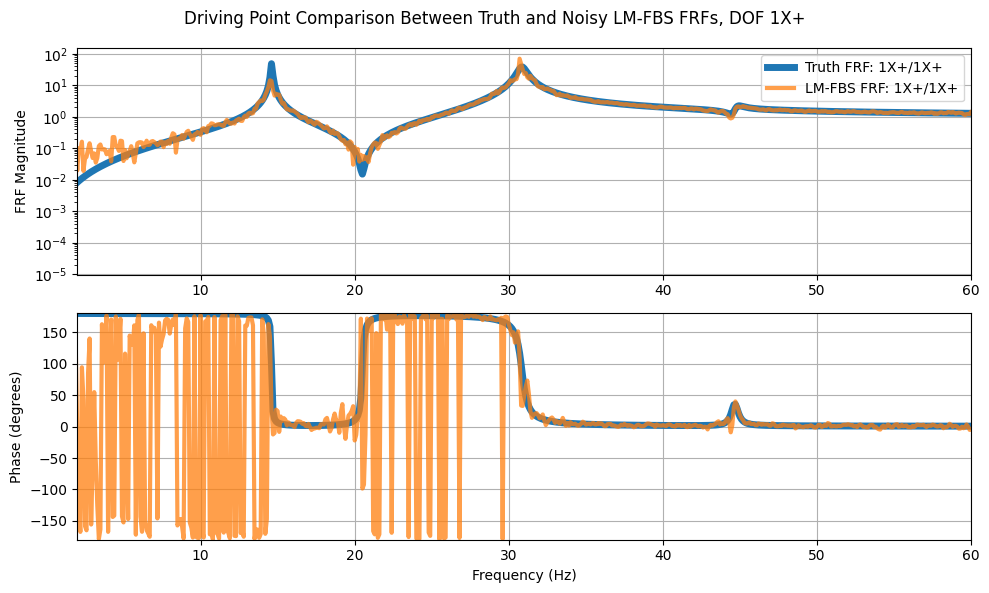

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[0, 0].ordinate), 
               label='Truth FRF: 1X+/1X+', linewidth=5)
ax[0].semilogy(freq_noised, np.abs(fbs_coupled_frfs[0, 0].ordinate), 
               label='LM-FBS FRF: 1X+/1X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[0, 0].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_noised, np.angle(fbs_coupled_frfs[0, 0].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs, DOF 1X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

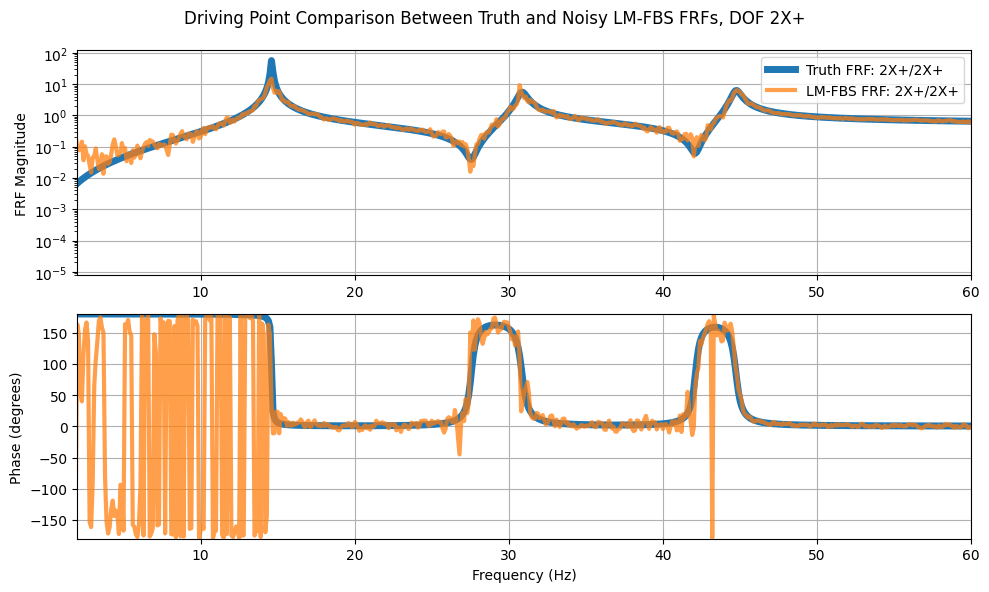

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[1, 1].ordinate), 
               label='Truth FRF: 2X+/2X+', linewidth=5)
ax[0].semilogy(freq_noised, np.abs(fbs_coupled_frfs[1, 1].ordinate), 
               label='LM-FBS FRF: 2X+/2X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[1, 1].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_noised, np.angle(fbs_coupled_frfs[1, 1].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs, DOF 2X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

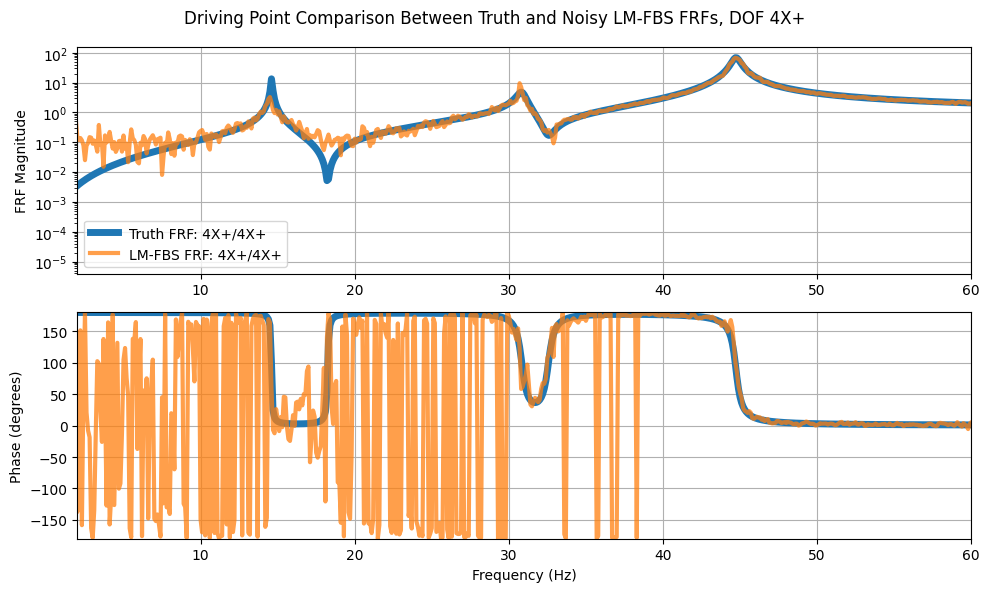

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[2, 2].ordinate), 
               label='Truth FRF: 4X+/4X+', linewidth=5)
ax[0].semilogy(freq_noised, np.abs(fbs_coupled_frfs[2, 2].ordinate), 
               label='LM-FBS FRF: 4X+/4X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[2, 2].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_noised, np.angle(fbs_coupled_frfs[2, 2].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs, DOF 4X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

### Influence of Errors in the Kernel FRFs
Recall that the coupling force for the FBS coupling is computed via the inverse problem below, where the inverted portion of the equation is referred to as the kernel. 

$$
g_3^b=(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a&-h_{33}^b&-h_{34}^b\end{Bmatrix}\begin{Bmatrix}f_1^a\\f_2^a\\f_3^b\\f_4^b\end{Bmatrix}
$$

The quality and conditioning of the kernel holds a special importance in FBS since it is inverted to perform the coupling. This significance can be demonstrated by redoing the FBS coupling after replacing kernel FRFs with error free FRFs.  

```{note}
The kernel in the FBS equation is composed of the driving point and reciprocal FRFs for the coupling DOFs on the different substructures. Recognizing this structure in the equation makes it easy to pay extra attention to the quality of the kernel FRFs. 
```

In [18]:
system_a_frf_clean_driving_point = system_a_frf_noise.copy().extract_elements_by_abscissa(0,60)
system_a_frf_clean_driving_point[1,1].ordinate = system_a_truth_frfs[1,1].ordinate

system_b_frf_clean_driving_point = system_b_frf_noise.copy().extract_elements_by_abscissa(0,60)
system_b_frf_clean_driving_point[0,0].ordinate = system_b_truth_frfs[0,0].ordinate

In [19]:
block_diagonal_clean_driving_point = sdpy.TransferFunctionArray.block_diagonal_frf((system_a_frf_clean_driving_point, 
                                                                                    system_b_frf_clean_driving_point))
fbs_coupled_clean_driving_point = block_diagonal_clean_driving_point.substructure_by_coordinate(coupling_dofs)[coupled_frf_dofs]

A graphical comparison between the redone FBS coupled and truth driving point FRFs shows that the accuracy of the FBS coupling is significantly improved when the kernel FRFs are error free, even though the rest of the FRFs still have moderate measurement errors. However, it should be noted that the FBS coupled FRFs still have significant errors at the low responding frequencies in the coupled FRFs. 

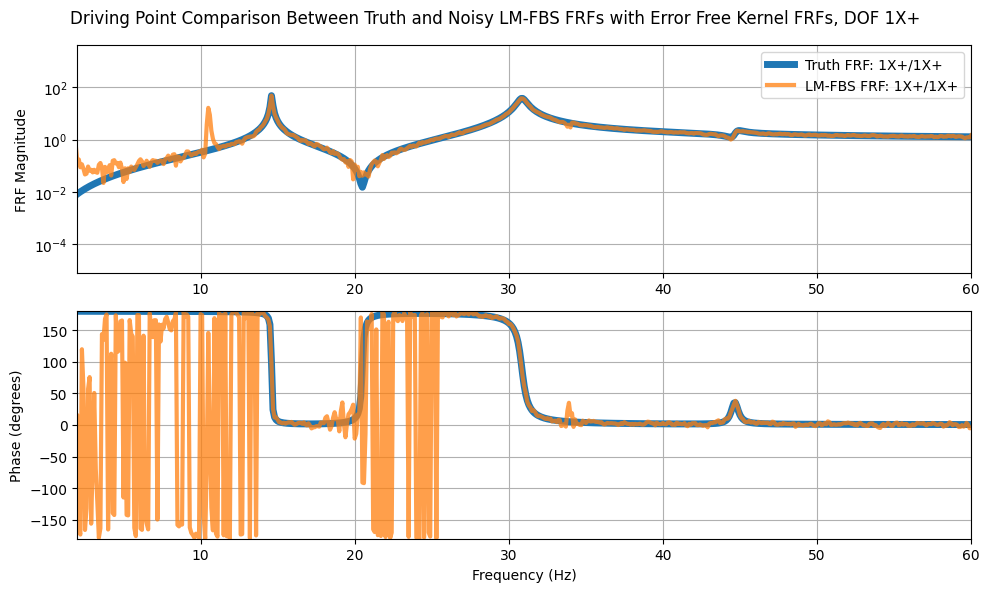

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[0, 0].ordinate), 
               label='Truth FRF: 1X+/1X+', linewidth=5)
ax[0].semilogy(freq_truth, np.abs(fbs_coupled_clean_driving_point[0, 0].ordinate), 
               label='LM-FBS FRF: 1X+/1X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[0, 0].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_truth, np.angle(fbs_coupled_clean_driving_point[0, 0].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs with Error Free Kernel FRFs, DOF 1X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

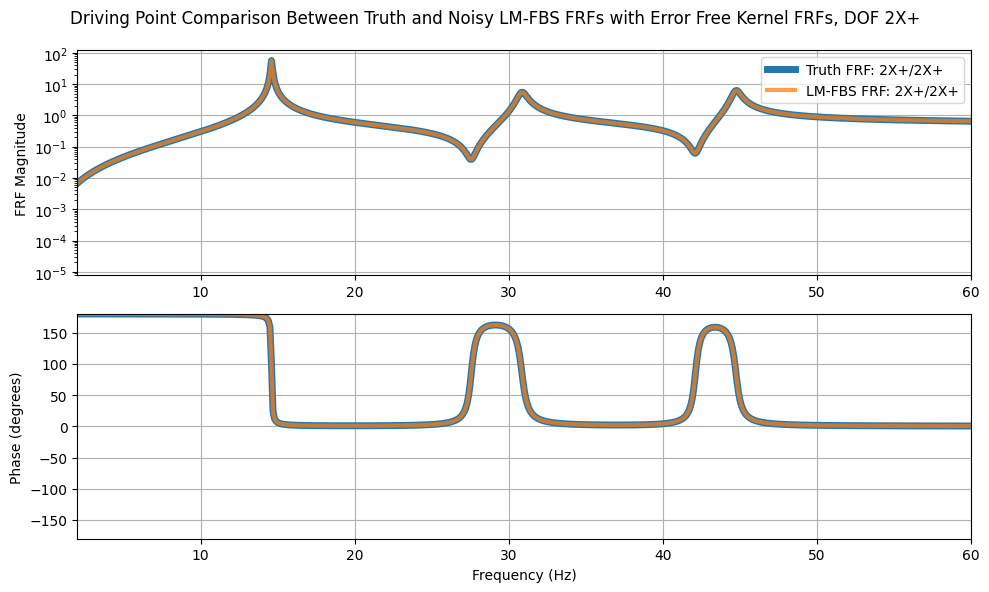

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[1, 1].ordinate), 
               label='Truth FRF: 2X+/2X+', linewidth=5)
ax[0].semilogy(freq_truth, np.abs(fbs_coupled_clean_driving_point[1, 1].ordinate), 
               label='LM-FBS FRF: 2X+/2X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[1, 1].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_truth, np.angle(fbs_coupled_clean_driving_point[1, 1].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs with Error Free Kernel FRFs, DOF 2X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

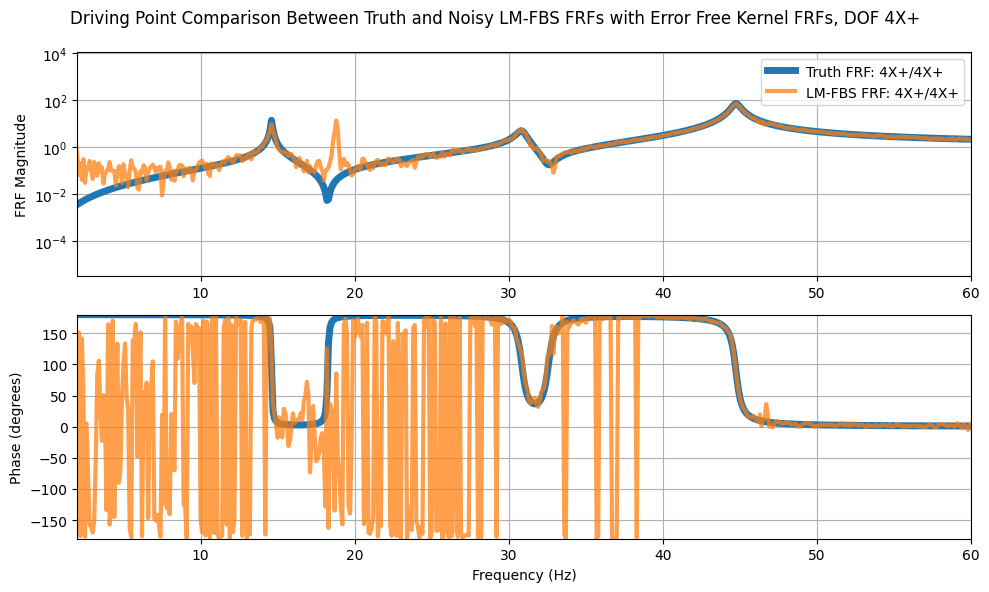

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq_truth, np.abs(coupled_system_frfs[2, 2].ordinate), 
               label='Truth FRF: 4X+/4X+', linewidth=5)
ax[0].semilogy(freq_truth, np.abs(fbs_coupled_clean_driving_point[2, 2].ordinate), 
               label='LM-FBS FRF: 4X+/4X+', linewidth=3, alpha=0.75)
ax[0].set_xlim(left=2, right=60)
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq_truth, np.angle(coupled_system_frfs[2, 2].ordinate)*180/np.pi, 
           linewidth=5)
ax[1].plot(freq_truth, np.angle(fbs_coupled_clean_driving_point[2, 2].ordinate)*180/np.pi, 
           linewidth=3, alpha=0.75)
ax[1].set_xlim(left=2, right=60)
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Noisy LM-FBS FRFs with Error Free Kernel FRFs, DOF 4X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

## Conclusions 
This notebook demonstrated how measurement errors can lead to significant errors in the FBS coupled FRFs. It also demonstrated how the kernel FRFs hold a special significance in the FBS coupling, since removing the measurement errors in the kernel FRFs significantly improved the accuracy of the FBS coupling. 

```{tip}
Practitioners should pay special attention to the quality of the kernel FRFs (the driving point and cross FRFs between the coupling DOFs on each substructure) that will be used in the FBS coupling to minimize errors in the coupled FRFs. 
```